In [ ]:
import numpy as np
import glob
import random
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
from glob import glob

from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


import tensorflow as tf

random.seed(98)
np.random.seed(98)

In [ ]:
# !unzip "/content/drive/MyDrive/Breast_cancer/breast_cancer.zip" -d "/content/drive/MyDrive/Breast_cancer"

In [ ]:
breast_img = glob('/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/**/*.png',recursive=True)

In [ ]:
for imgname in breast_img[:3]:
    print(imgname)  

/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x951_y701_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1351_y1151_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1551_y601_class0.png


In [ ]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)
    
    elif img[-5] == '1' :
        can_img.append(img)
breast_img[0]

'/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x951_y701_class0.png'

In [ ]:
non_num = len(non_img)
can_num = len(can_img)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 7226
Number of Images in IDC (+) : 1965
Total Number of Images : 9191


In [ ]:
from os import listdir
base_path = "/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
print(total_images)

In [ ]:
import pandas as pd
data = pd.DataFrame(index=np.arange(0, total_img_num), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

In [ ]:
data.shape

(277524, 3)

In [ ]:
data.target = data.target.astype(np.int)
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

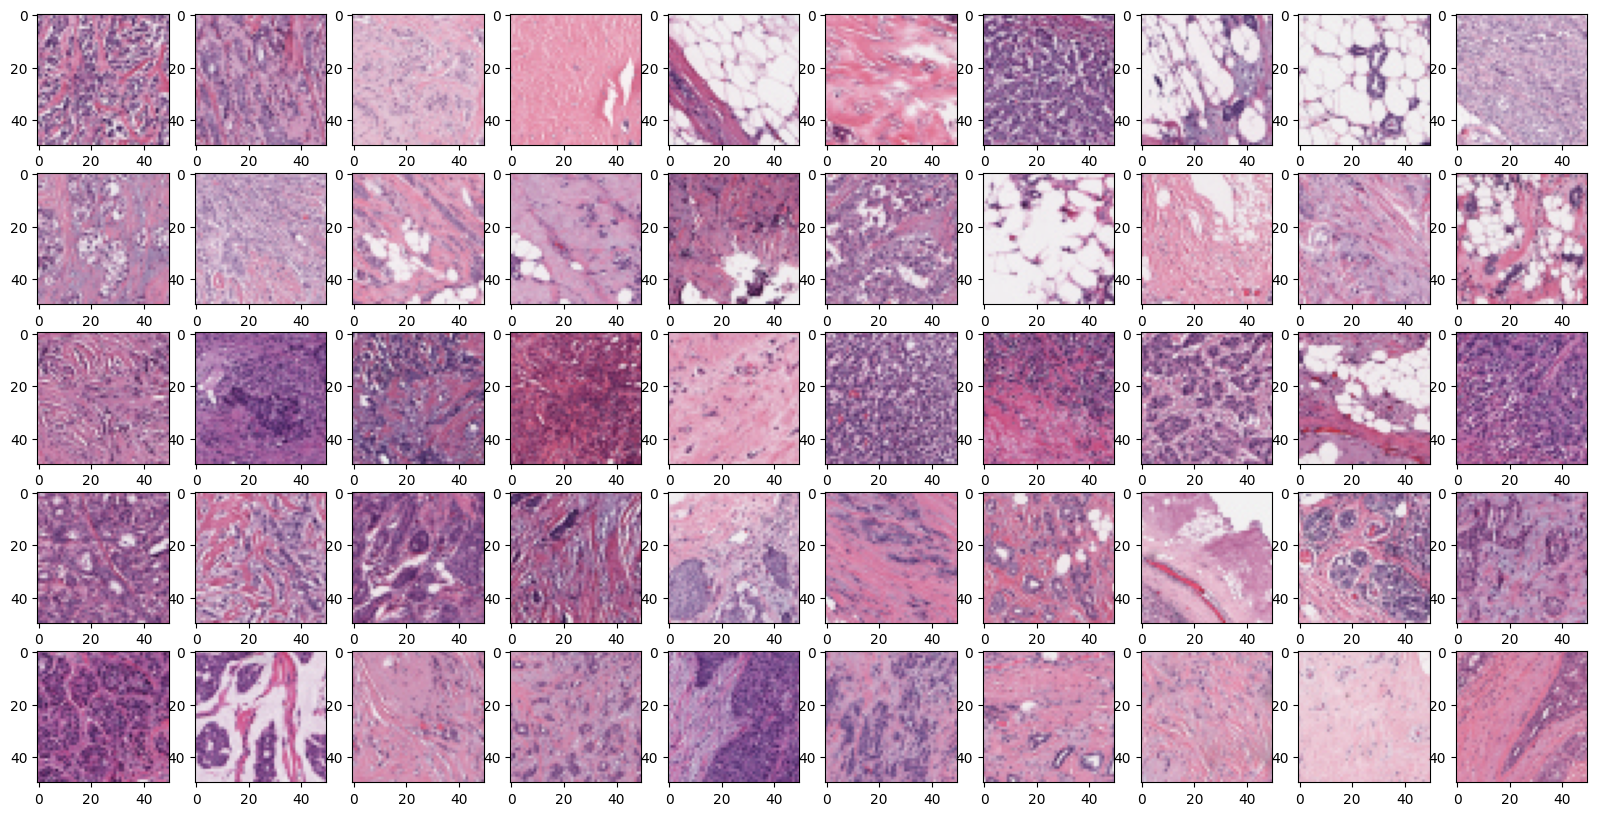

In [ ]:
#Cancer Patches
from skimage.io import imread
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

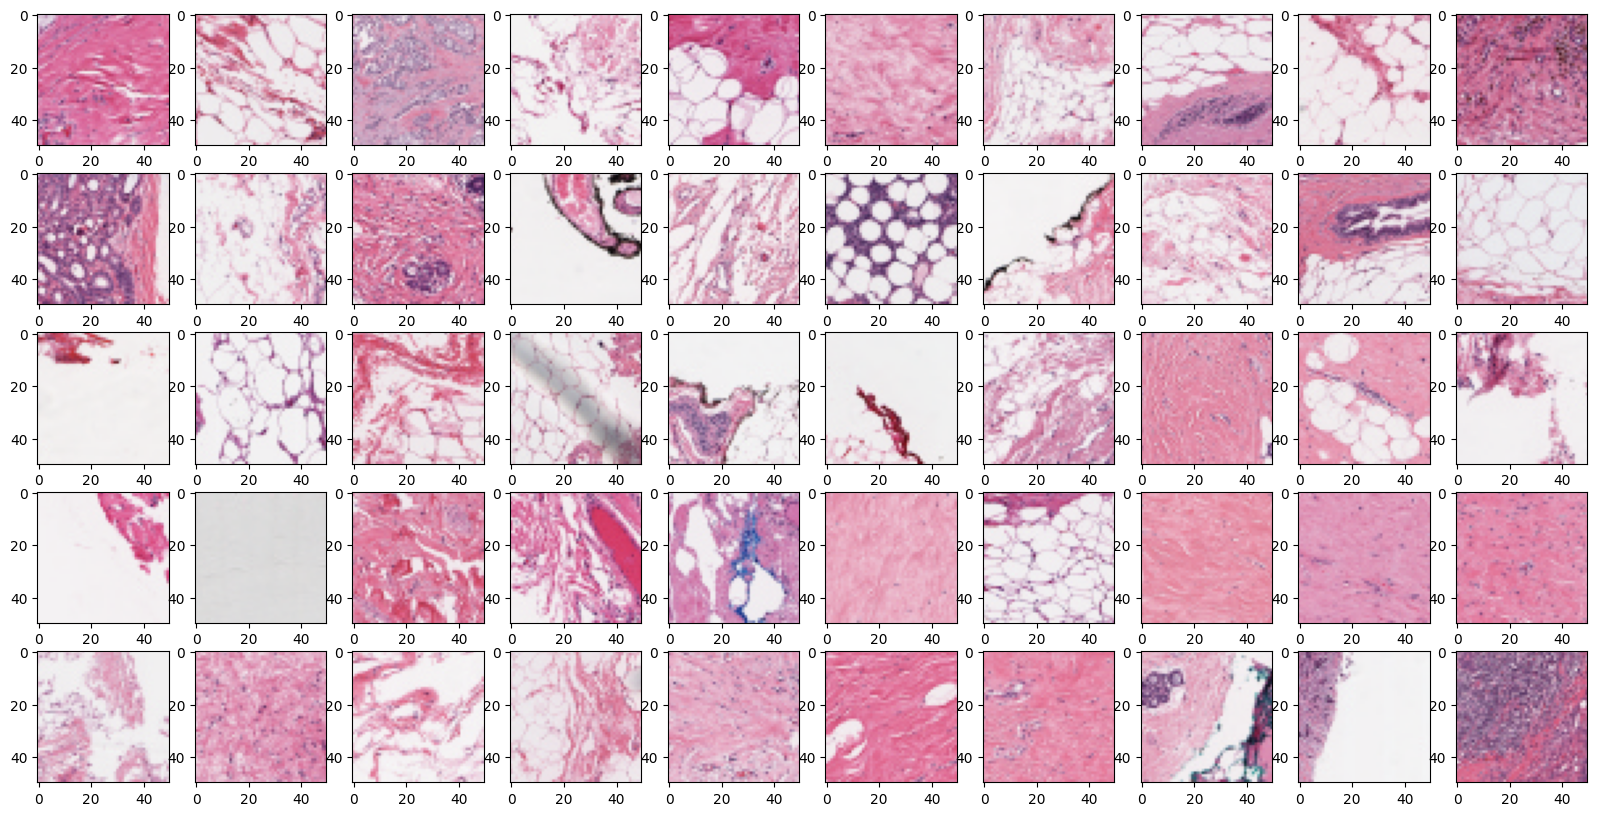

In [ ]:
#Healthy Patches
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

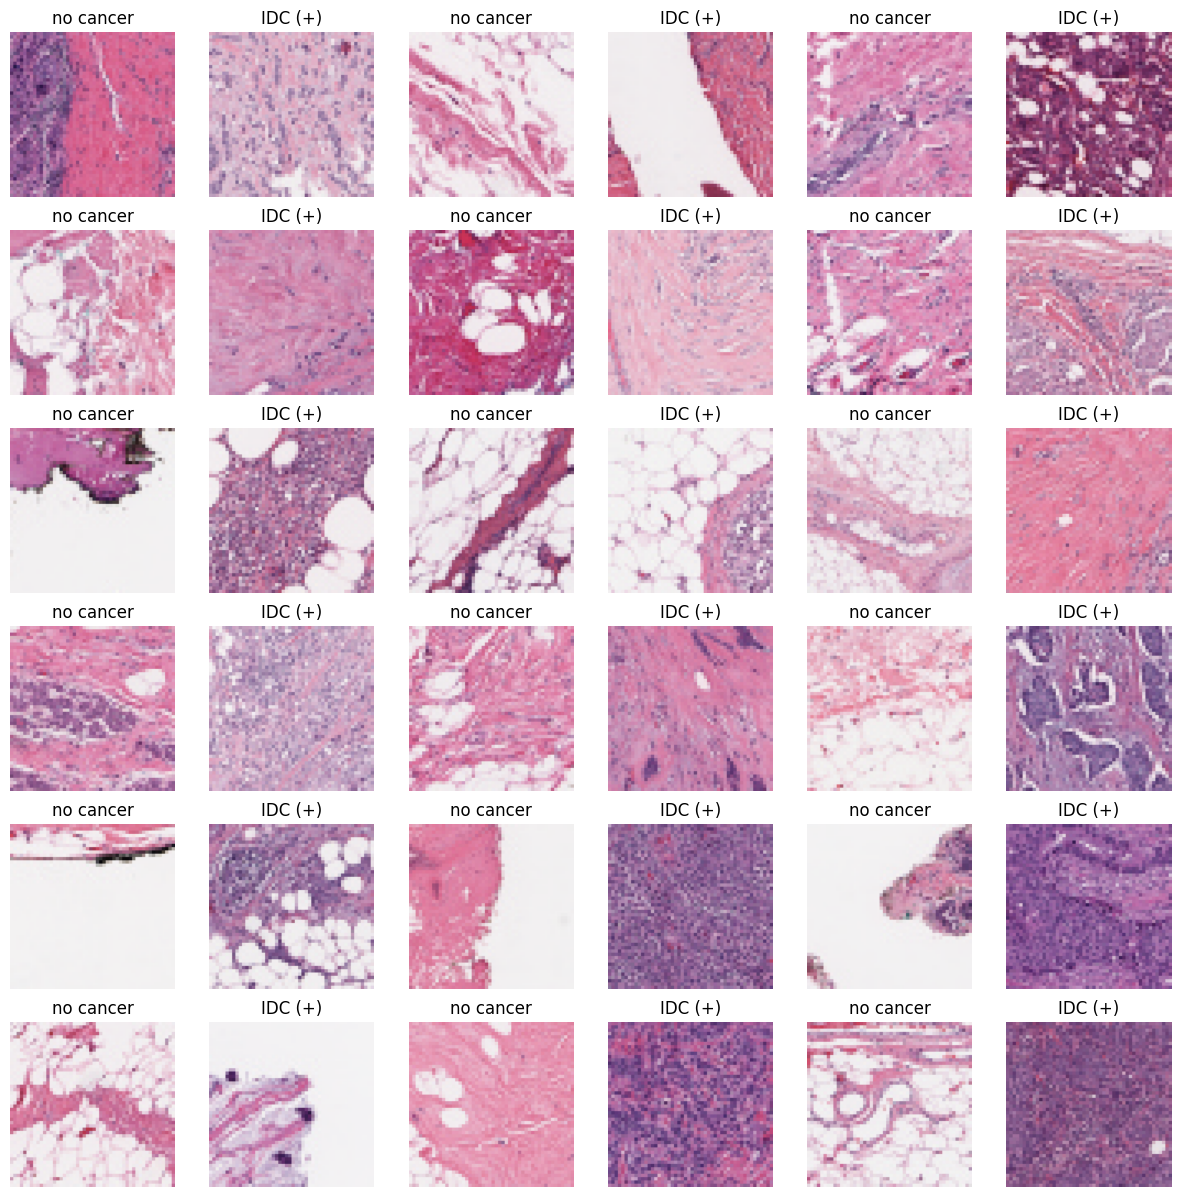

In [ ]:
#Combined patches
import tensorflow
import keras
from tensorflow.keras.preprocessing import image
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_img), 18)
some_can = np.random.randint(0, len(can_img), 18)

s = 0
for num in some_non:
    
        img = image.load_img((non_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_can:
    
        img = image.load_img((can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [ ]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [ ]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

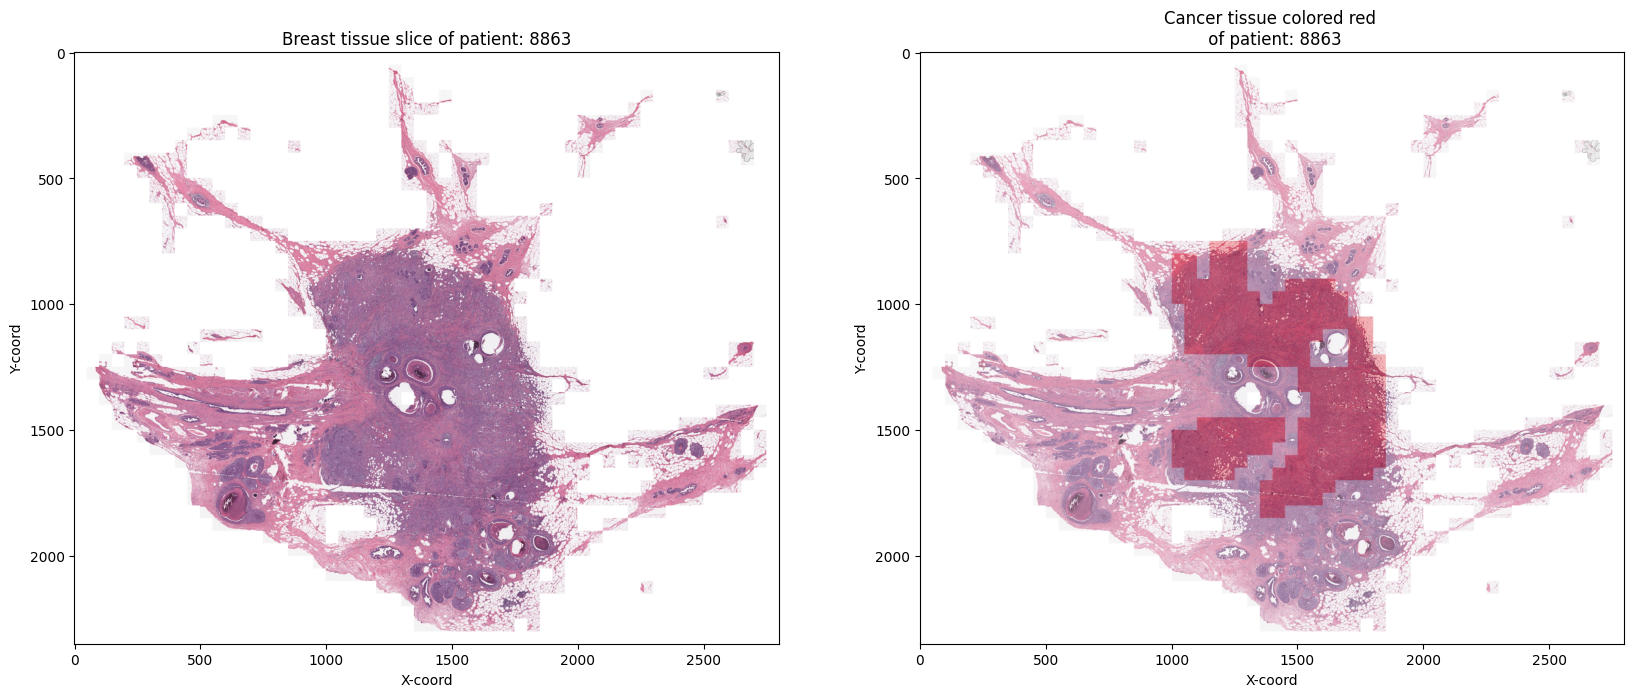

In [ ]:
patient_id = "8863"
visualise_breast_tissue(patient_id)

In [ ]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1,1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")

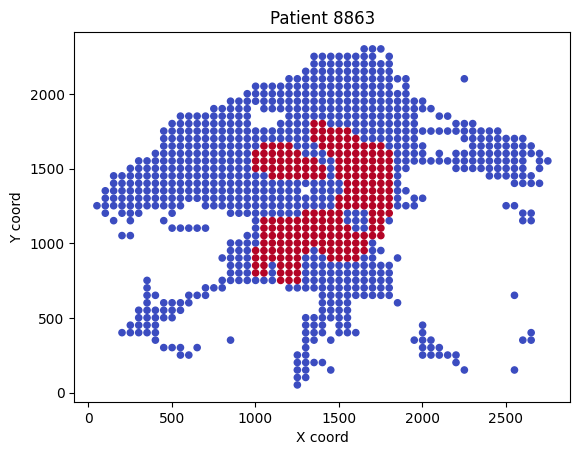

In [ ]:
patient_id = "8863"
visualise_breast_tissue_binary(patient_id)

In [ ]:
#Data preprocessing

data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [ ]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [ ]:
from torch.utils.data import Dataset
class BreastCancerDataset(Dataset):
    
    def __init__(self, df):
        self.states = df
        
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [ ]:
train_dataset = BreastCancerDataset(train_df)
dev_dataset = BreastCancerDataset(dev_df)
test_dataset = BreastCancerDataset(test_df)

In [ ]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

In [ ]:
print("Training Dataset : ",dataset_sizes["train"])
print("Dev Dataset : ",dataset_sizes["dev"])
print("Test Dataset : ",dataset_sizes["test"])

Training Dataset :  189156
Dev Dataset :  40747
Test Dataset :  47621


In [ ]:
plt.imshow(image_datasets["test"].__getitem__(0)['image'])

In [ ]:
#Creating database suitable for tensorflow
train_images = []
train_labels = []
# for i in range(dataset_sizes["train"]):
for i in range(1000):
    train_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    train_labels.append(image_datasets["train"].__getitem__(i)['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
train_images.shape

(1000, 50, 50, 3)

In [ ]:
#Creating database suitable for tensorflow
test_images = []
test_labels = []
# for i in range(dataset_sizes["test"]):
for i in range(1000,2000):
    test_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    test_labels.append(image_datasets["train"].__getitem__(i)['label'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
test_images.shape 

(1000, 50, 50, 3)

In [ ]:
#Training
# BATCH_SIZE = 32
# NUM_CLASSES = 2

# from tensorflow.keras import datasets, layers, models
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
from matplotlib.image import imread
import cv2

some_non_img = random.sample(non_img, len(can_img))
some_can_img = random.sample(can_img, len(can_img))

non_img_arr = []
can_img_arr = []

for img in some_non_img:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in some_can_img:
    
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [ ]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print('X shape : {}' .format(X.shape))

X shape : (157572, 50, 50, 3)


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size = 0.3, random_state = 7)

rate = 0.5
num = int(X.shape[0] * rate)

X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_predict shape : {}' .format(X_predict.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_true shape : {}' .format(y_true.shape))

X_train shape : (78786, 50, 50, 3)
X_test shape : (31514, 50, 50, 3)
X_predict shape : (47272, 50, 50, 3)
y_train shape : (78786, 2)
y_test shape : (31514, 2)
y_true shape : (47272, 2)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
from keras.optimizers import Adam
Adam = Adam(learning_rate = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 100)

Epoch 1/10
788/788 [==============================] - 1935s 2s/step - loss: 0.3064 - accuracy: 0.8716 - val_loss: 0.3233 - val_accuracy: 0.8623
Epoch 2/10
788/788 [==============================] - 1933s 2s/step - loss: 0.2776 - accuracy: 0.8804 - val_loss: 0.3368 - val_accuracy: 0.8563
Epoch 3/10
788/788 [==============================] - 1876s 2s/step - loss: 0.2681 - accuracy: 0.8870 - val_loss: 0.3116 - val_accuracy: 0.8699
Epoch 4/10
788/788 [==============================] - 1928s 2s/step - loss: 0.2603 - accuracy: 0.8880 - val_loss: 0.3239 - val_accuracy: 0.8662
Epoch 5/10
788/788 [==============================] - 2213s 3s/step - loss: 0.2565 - accuracy: 0.8902 - val_loss: 0.3398 - val_accuracy: 0.8603
Epoch 6/10
788/788 [==============================] - 1949s 2s/step - loss: 0.2514 - accuracy: 0.8907 - val_loss: 0.3131 - val_accuracy: 0.8644
Epoch 7/10
788/788 [==============================] - 1916s 2s/step - loss: 0.2455 - accuracy: 0.8932 - val_loss: 0.3297 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Breast_Cancer_models/cnn_model.h5')

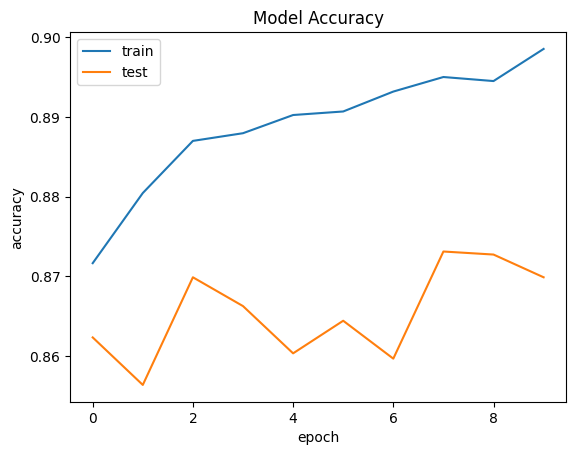

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

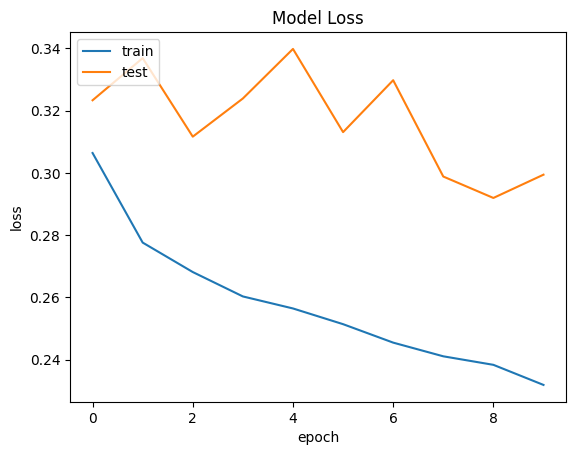

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
P = model.predict(X_predict)

true = 0
for i in range(X_predict.shape[0]):
    if(np.argmax(P[i]) == np.argmax(y_true[i])):
        true = true + 1

pre_accuracy = 100 * float(true/X_predict.shape[0])        
print('Predict Accuracy: {}' .format(pre_accuracy))

1478/1478 [==============================] - 250s 168ms/step
Predict Accuracy: 87.02191572178033


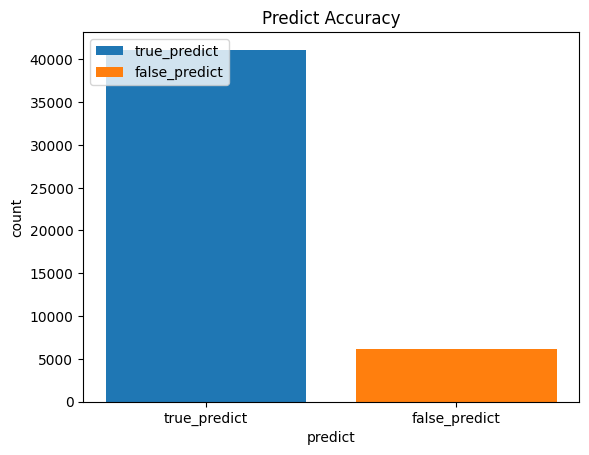

In [ ]:
import seaborn as sns
false = len(X_predict) - true

predict = [true, false]
label = ['true_predict', 'false_predict']

plt.bar(label[0], predict[0])
plt.bar(label[1], predict[1])
plt.title('Predict Accuracy')
plt.xlabel('predict')
plt.ylabel('count')
plt.legend(['true_predict', 'false_predict'], loc='upper left')
plt.show()

985/985 [==============================] - 162s 164ms/step


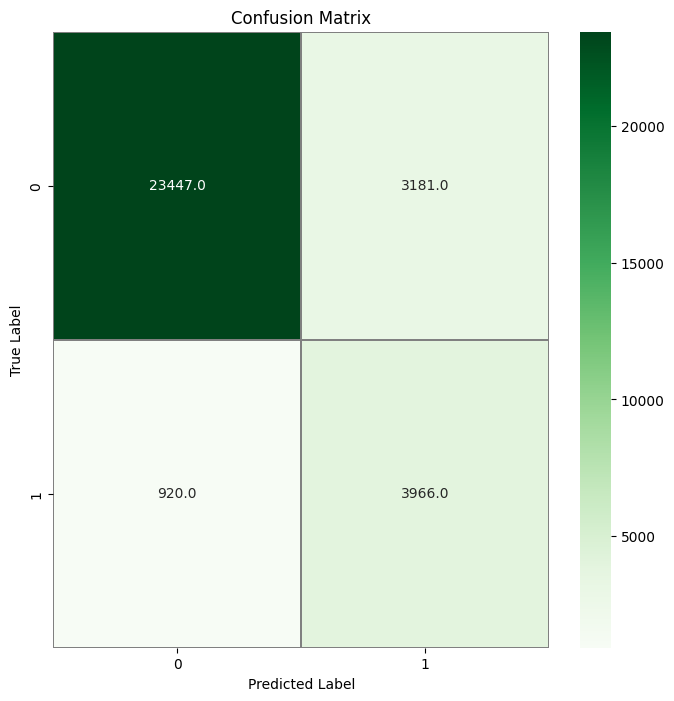

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#single image prediction
def predict_single_image(idx):
    img = []
    img.append(np.array(image_datasets["train"].__getitem__(idx)['image']))
    img = np.array(img)
    print("Cancer : 1","No Cancer : 0")
    print("True Lable : ",image_datasets["train"].__getitem__(idx)['label'])
    print("Predicted Label : ", model.predict(img).argmax(axis=-1)[0])

In [ ]:
result = model.evaluate(X_test, y_test, batch_size = 50)
print('Test Loss, Test Accuracy :', result)

631/631 [==============================] - 156s 247ms/step - loss: 0.2994 - accuracy: 0.8699
Test Loss, Test Accuracy : [0.29940447211265564, 0.8698673844337463]
